### Modélisation : 

- L'objectif dans cette partie du projet est de construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Rappel de la TARGET :
    * 1 :  client avec difficultés de paiement: il a eu un retard de paiement de plus de X jours sur au moins une des Y premières échéances du prêt de notre échantillon
    * 0 : Tous les autres cas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time
import fnmatch

# Pour les warnings
import warnings

warnings.filterwarnings("ignore")

import logging

logging.disable(logging.WARNING)  # disable WARNING, INFO and DEBUG logging everywhere
# Pour le ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from pandas import MultiIndex, Int16Dtype
from pandas import MultiIndex, Int64Index
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
# Modification des paramètres d'affichages des colonnes, lignes et largeurs des colonnes pour obtenir le plus d'information
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", None)
pd.set_option("float_format", lambda x: "%.4f" % x)

#### Import du fichier : 

In [2]:
data = pd.read_csv(
    "/Users/hananemaghlazi/Desktop/Datascientist/Projets_Formation/P7_MAGHLAZI_Hanane/train.csv"
)
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0


In [4]:
data.shape

(307507, 790)

- Tester la modélisation sur un échantillon : 

In [3]:
# J'extrais un échantillon 1 % :
data_sample = data.sample(frac=0.01).round(3)
data_sample.shape

(3075, 790)

In [6]:
data_sample.TARGET.value_counts(normalize="True")

0.0000   0.9174
1.0000   0.0826
Name: TARGET, dtype: float64

In [7]:
data_sample.TARGET.value_counts()

0.0000    2821
1.0000     254
Name: TARGET, dtype: int64

#### Régression logistique en tant que baseline : 

- Séparation du jeu de données en jeu d'entrainement et de test : 
- Séparation : 80% entrainement, 20% test

In [4]:
# Les features
X = data_sample.drop(["TARGET", "SK_ID_CURR"], axis=1)
# La target
Y = data_sample[["TARGET"]]
# Division du dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, stratify=Y, random_state=42
)
print("shape of original dataset :", data_sample.shape)
print("shape of input - training set", X_train.shape)
print("shape of output - training set", y_train.shape)
print("shape of input - testing set", X_test.shape)
print("shape of output - testing set", y_test.shape)

shape of original dataset : (3075, 790)
shape of input - training set (2460, 788)
shape of output - training set (2460, 1)
shape of input - testing set (615, 788)
shape of output - testing set (615, 1)


In [9]:
Y.head()

,TARGET
258340,0.0000
181776,0.0000
189517,0.0000
7089,1.0000
306662,0.0000


In [10]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Enti

In [12]:
print("Classe 1, sans SMOTE ", (y_train == 1).sum())
print("Classe 0, sans SMOTE:", (y_train == 0).sum())

Classe 1, sans SMOTE  TARGET    203
dtype: int64
Classe 0, sans SMOTE: TARGET    2257
dtype: int64


- Preprocessing avant modélisation:
- Utilisation du MinMaxScaler pour la standardisation des données

In [5]:
lr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=42))
lr

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [6]:
# Fonction qui va entrainer le modèle,prédire et évaluer l'ensemble des modèles
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_true = y_test
    print(classification_report(y_true, y_pred))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC : %0.4f" % roc_auc)

    fig = plt.figure(figsize=(20, 15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")

    plt.subplot(222)

    fper, tper, thresholds = roc_curve(y_true, y_pred_proba)
    plt.plot(fper, tper, color="red", label="AUC = %0.4f" % roc_auc)
    plt.plot([0, 1], [0, 1], color="green", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Curve")
    plt.legend()
    plt.show()

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       569
         1.0       0.14      0.02      0.04        46

    accuracy                           0.92       615
   macro avg       0.53      0.51      0.50       615
weighted avg       0.87      0.92      0.89       615

AUC : 0.7171


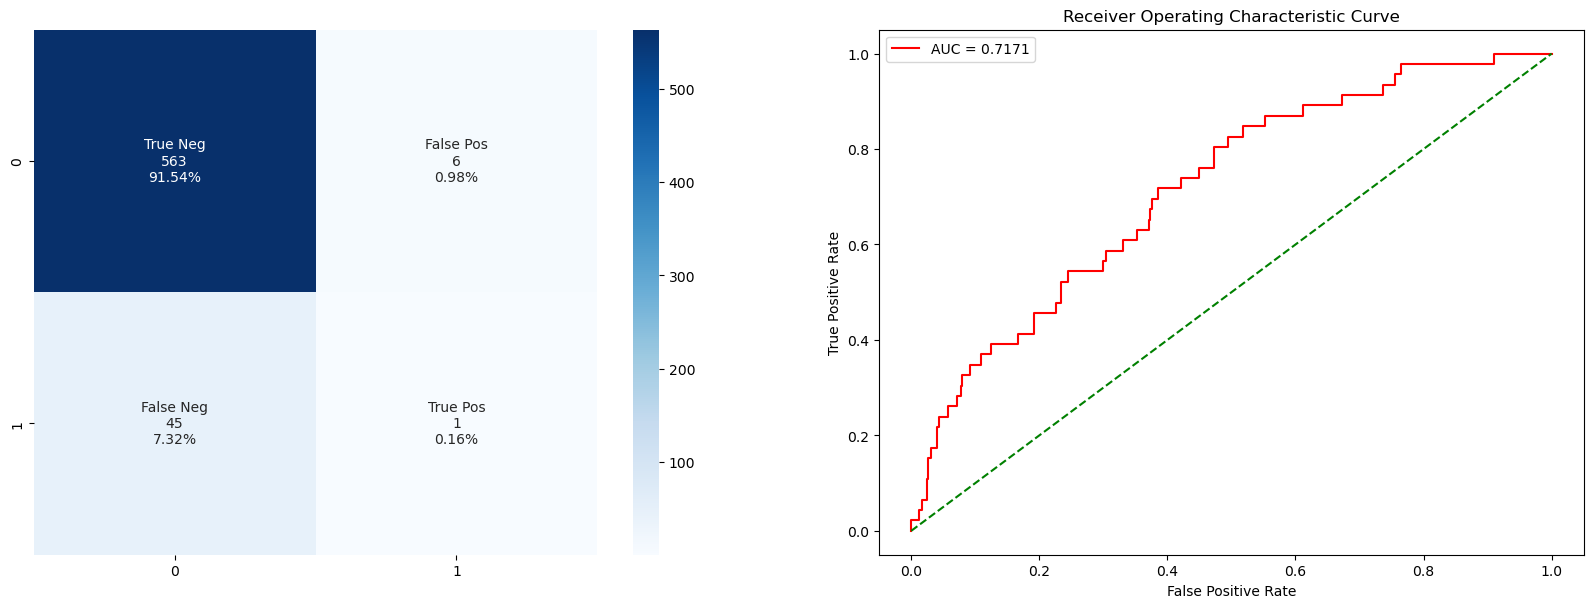

In [7]:
evaluation(lr)

- De bons résultats pour la target 0 mais pas pour la target 1
- Le désilquilibre entre les deux classes engendre de mauvaises performances sur la classe minoritaire
- Un problème avec la classification déséquilibrée est qu'il y a trop peu d'exemples de la classe minoritaire pour qu'un modèle apprenne efficacement la frontière de décision.
- Dans un premier temps tester différents modèles avec les memes classes
- Dans un deuxième temps avec classe équilibrés

- Tester différents algorithmes de machine learning avec parametres de base : 

     RandomForestClassifier: 

In [8]:
rf = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=42))
rf

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

    XGBClassifier : 

In [9]:
xgb = make_pipeline(MinMaxScaler(), XGBClassifier(random_state=42))
xgb

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               gamma=None, gpu_id=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
                               subsample=None, tree_method=None,
                               validate_parameters=None, verbosity=None))])

    GradientBoostingClassifier : 

In [10]:
grb = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=42))
grb

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])

    LightGBMClassifier: 

In [19]:
lgt = make_pipeline(MinMaxScaler(), LGBMClassifier(random_state=42))
lgt

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [11]:
model_pipeline = {
    "RandomForestClassifier": rf,
    "Gradientboosting": grb,
    "Xgbregressor": xgb,
    #"LightGBM": lgt,
}

In [12]:
def metrics_models(model_pipeline):
    
    results = []
    cm_list = []
    for model_pipeline_name, model in model_pipeline.items():
        model.fit(X_train, y_train.values.ravel())
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy = accuracy_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        f1 = f1_score(y_test, model.predict(X_test))
        cm_list.append(confusion_matrix(y_test, model.predict(X_test)))

        results.append([model_pipeline_name, auc, accuracy, precision, recall, f1])
        df = pd.DataFrame(
            results, columns=["Models", "Auc", "Accuracy", "Precision", "Recall", "F1"]
        )
    return df, cm_list

In [13]:
df_results, cm_list = metrics_models(model_pipeline)

[18:07:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
df_results

,Models,Auc,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,0.638783,0.925203,0.0,0.000000,0.000000
1,Gradientboosting,0.693551,0.928455,1.0,0.043478,0.083333
2,Xgbregressor,0.692940,0.928455,1.0,0.043478,0.083333


- Visualisation des matrices de confusion des modèles testés: 

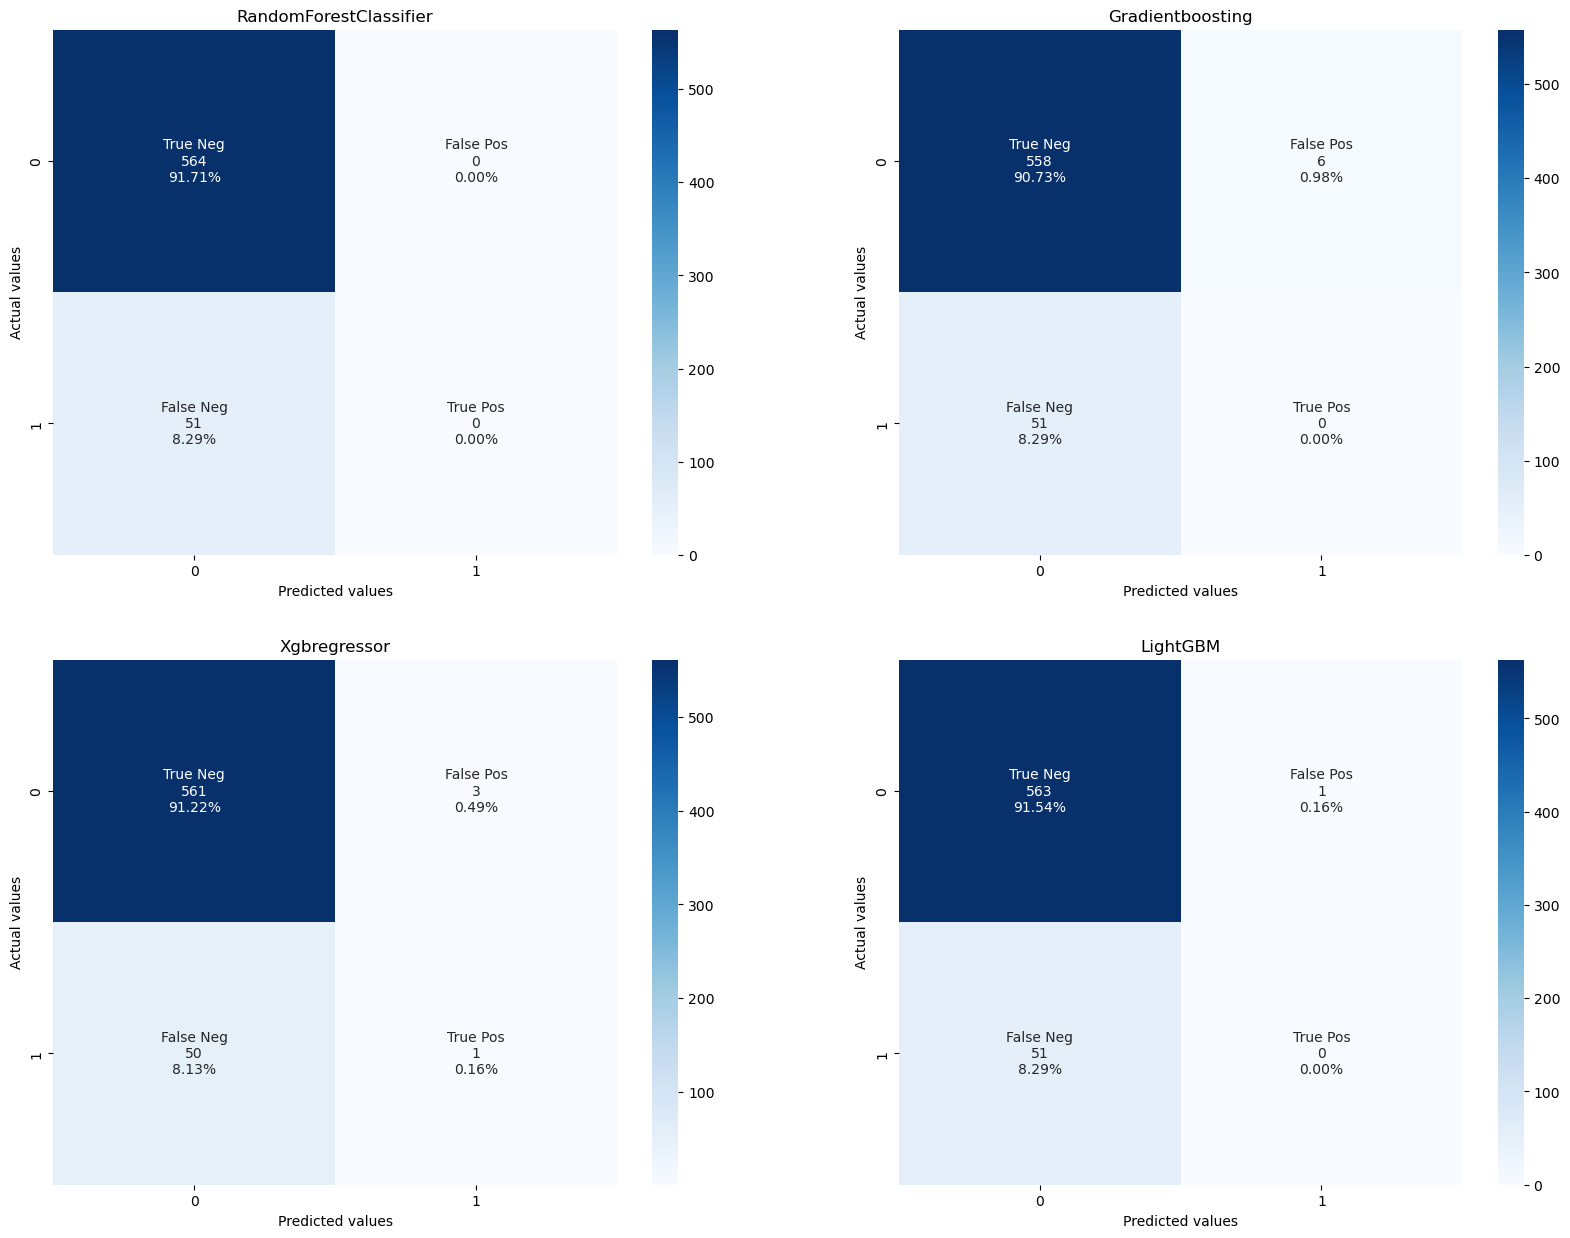

In [24]:
list_models = [
    
    "RandomForestClassifier",
    "Gradientboosting",
    "Xgbregressor",
    "LightGBM",
]
# Visualisation des matrices de confusion
fig = plt.figure(figsize=(20, 15))

for i in range(len(cm_list)):
    model = list_models[i]
    cm = cm_list[i]
    sub = fig.add_subplot(2, 2, i + 1).set_title(model)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    cm_plot = sns.heatmap(cm, fmt="", annot=labels, cmap="Blues")
    cm_plot.set_xlabel("Predicted values")
    cm_plot.set_ylabel("Actual values")

- Amélioration des modèles:   Hyperparameters Tuning par des grid search: 

In [25]:
# Utilisation du MinMaxScaler() pour normalisation des données dans la pipeline
preprocessor = make_pipeline(MinMaxScaler())
preprocessor

Pipeline(steps=[('minmaxscaler', MinMaxScaler())])

- Regression logistique : 

In [25]:
# Définition du modèle
classifier = LogisticRegression
# Définition des Hyperparamètres
param_lr = {
    "C": [0.001, 0.01],
    "max_iter": [100],
}

# Définition de la Gridsearch dans la pipeline

lr_grid_cv = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "grid_search_rfr",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_lr,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                refit=True,
                n_jobs=None,
                verbose=2,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [26]:
lr_grid_cv

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('grid_search_rfr',
                 GridSearchCV(cv=5,
                              estimator=LogisticRegression(random_state=42),
                              param_grid={'C': [0.001, 0.01],
                                          'max_iter': [100]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=2))])

<IPython.core.display.Javascript object>

- RandomForest Classifier

In [7]:
#A voir
#fbeta_scoreLR = fbeta_score(y_test, Y_predLR, average='weighted', beta=0.5)

In [27]:
# Définition du modèle
classifier = RandomForestClassifier
# Définition des Hyperparamètres
param_rf = {
    "max_depth": [2, 4, 6, 8, 10],  # Max depth of the tree
    "n_estimators": [25, 50],  # Number of decision trees
    "min_samples_leaf": [1, 5, 10],  # Minimum number of data points in a leaf node
    "max_features": [
        "auto",
        "sqrt",
    ],  # Maximum number of features considered while splitting
    "bootstrap": [True, False],  # Sampling with or without replacement
}

# Définition de la Gridsearch dans la pipeline

rf_grid_cv = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "grid_search_rfr",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_rf,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                refit=True,
                n_jobs=None,
                verbose=2,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [28]:
rf_grid_cv

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('grid_search_rfr',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              param_grid={'bootstrap': [True, False],
                                          'max_depth': [2, 4, 6, 8, 10],
                                          'max_features': ['auto', 'sqrt'],
                                          'min_samples_leaf': [1, 5, 10],
                                          'n_estimators': [25, 50]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=2))])

<IPython.core.display.Javascript object>

- XGBoost : 

In [29]:
# définition des Hyperparamètres
classifier = XGBClassifier
param_xgb = {
    "max_depth": [2, 4, 6],
    "learning_rate": [0.1, 0.01, 0.05],
    "n_estimators": [20],
    "min_child_weight": [1, 3, 6],
    "gamma": [0.0, 0.4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "objective": ["binary:logistic"],
    "nthread": [4],
    # "scale_pos_weight" : [1],
    # "seed" : [2],
    "reg_alpha": [0.01, 0.05],
}

xgb_grid_cv = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "grid_search_xgb",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_xgb,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=None,
                verbose=2,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [30]:
xgb_grid_cv

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('grid_search_xgb',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rat...
                                                      validate_parameters=None,
                                                      verbosity=None),
                              param_grid={'colsample_bytree': [0.6, 0.8],
                                          'gamma': [0.0, 0.4],
                                          'learning_rate': [0.1, 0.01, 0.05],
                                          'max_depth': [2, 4, 6],
                                          'min_child_weight': [1, 3, 6],
                                          'n_estimators': [20], 'nthread': [4],
                                          'objective': ['binary:logistic'],
                                          'reg_alpha': [0.01, 0.05],
                                          'subsample': [0.6, 0.7, 0.8]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=2))])

<IPython.core.display.Javascript object>

- LightGBM : 

In [8]:
# définition des Hyperparamètres
classifier = LGBMClassifier
param_lgbm = {
    # "nthread": [4],
    # "n_estimators": [100],
    "learning_rate": [0.02],
    # "colsample_bytree": [0.5, 0.9],
    # "subsample": [0.3, 0.4, 0.8],
    # "max_depth": [3, 4, 5, 6, 8],
    # "reg_alpha": [0.02, 0.04],
    # "reg_lambda": [0.02, 0.05, 0.07],
    # "min_split_gain": [0.02, 0.05, 0.07],
    # "min_child_weight": [30, 35, 40],
    # "silent": [True],
}

lgbm_grid_cv = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "grid_search_lgbm",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_lgbm,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1,
                verbose=False,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [9]:
lgbm_grid_cv

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('grid_search_lgbm',
                 GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
                              n_jobs=-1, param_grid={'learning_rate': [0.02]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=False))])

<IPython.core.display.Javascript object>

In [31]:
classifier = GradientBoostingClassifier

param_gbt = {
    #"criterion": ["friedman_mse"],
    "n_estimators": [2, 4,10,50], # The number of boosting stages to perform
    "max_depth": [2,3,5, 6], # The maximum depth limits the number of nodes in the tree
    "learning_rate": [0.02,0.1,0.5],#Learning rate shrinks the contribution of each tree by learning_rate
    "min_samples_split" :[0.1, 0.5, 1. ] ,# The minimum number of samples required to split an internal node
    "min_samples_leaf" : [0.1, 0.2,0.5] ,# The minimum number of samples required to be at a leaf node
}

gbt_grid_cv = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "grid_search_gbt",
            GridSearchCV(
                classifier(random_state=42),
                param_grid=param_gbt,
                cv=5,
                return_train_score=True,
                scoring="roc_auc",
                n_jobs=-1,
                refit=True,
                verbose=2,
            ),
        ),
    ]
)


<IPython.core.display.Javascript object>

In [32]:
gbt_grid_cv

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('grid_search_gbt',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.02, 0.1, 0.5],
                                          'max_depth': [2, 3, 5, 6],
                                          'min_samples_leaf': [0.1, 0.2, 0.5],
                                          'min_samples_split': [0.1, 0.5, 1.0],
                                          'n_estimators': [2, 4, 10, 50]},
                              return_train_score=True, scoring='roc_auc',
                              verbose=2))])

<IPython.core.display.Javascript object>

Tester les différents modèles : 

In [33]:
model_pipeline = {
    "LogisticRegression": lr_grid_cv,
    "RandomForestClassifier": rf_grid_cv,
    "Gradientboosting": gbt_grid_cv,
    "Xgbregressor": xgb_grid_cv,
    #'LGBMClassifier' : lgbm_grid_cv
}

<IPython.core.display.Javascript object>

In [32]:
df_results_grid=metrics_models(model_pipeline)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ..............................C=0.001, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.01, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.01, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.01, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.01, max_iter=100; total time=   0.0s
[CV] END ...............................C=0.01, max_iter=100; total time=   0.0s
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV

[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=5, n_estimators=5

[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=auto, min_samples_leaf=10, n_estimato

[CV] END bootstrap=True, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, min_samples_leaf=1, n_estimators=10

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=5, n_esti

[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1

[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=5, n_est

[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=8, max_features=auto, min_samples_leaf=10, n

[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:56:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:56:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:56:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:56:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:56:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:56:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:56:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:56:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:56:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:56:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:56:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:57:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:57:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:57:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:57:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:57:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:57:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:57:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:57:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:57:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:57:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:57:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:57:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:57:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:57:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, 

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:57:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:57:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:57:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:57:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:57:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:57:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:57:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:57:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:57:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:57:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:57:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:57:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:58:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:58:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:58:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:58:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:58:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:58:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:58:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:58:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:58:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:58:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:58:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:58:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:58:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:58:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:58:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:58:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:58:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:58:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:58:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:58:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:58:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:58:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:58:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:58:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:58:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:58:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:58:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:58:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:58:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:59:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:59:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:59:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:59:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:59:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:59:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:59:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[23:59:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:59:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:59:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[23:59:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:59:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:59:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[23:59:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.0

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:59:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:59:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:59:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:59:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[23:59:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:59:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[23:59:45] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:59:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[23:59:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[23:59:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[23:59:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[23:59:50] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:59:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:59:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[23:59:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[23:59:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:00:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:00:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:00:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:00:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:00:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:00:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:00:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:00:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:00:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:00:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[00:04:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=4; total time=   0.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.5, n_estimators=2; total time=   0.3s
[CV] END learni

[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=4; total time=   0.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.5, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0

[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.5, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=1.0, n_estimators=10; total time=   0.8s
[CV] END learning_rate

[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=8; total time=   1.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=10; total time=   0.8s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=10; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=1.0, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=10; total time=   0.8s
[CV] END learning_rat

[00:04:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=10; total time=   1.5s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=4; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.5, n_estimators=4; total time=   0.6s
[CV] END learni

[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=8; total time=   1.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=10; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.5, n_estimators=10; total time=   1.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=2; total time=   0.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=8; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.5, n_estimators=8; total time=   0.6s
[CV] END learning_rate

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.6s
[00:04:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=8; total time=   1.2s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=10; total time=   1.5s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=2; total time=   0.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max

[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=4; total time=   0.6s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=0.5, n_estimators=8; total time=   1.1s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=10; total time=   0.8s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=0.1, n_estimators=10; total time=   1.3s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=1.0, n_estimators=4; total time=   0.4s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.2, min_samples_split=1.0, n_estimators=8; total time=   0.7s
[CV] END learning_rate=0.02, max_depth=2, min_samples_leaf=0.5, min_samples_split=0.1, n_estimators=8; total time=   0.6s
[CV] END learning_rate

[00:04:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:04:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:04:50] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:04:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:04:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:05:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.6s
[00:05:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:05:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:05:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, 

[00:05:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:05:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:05:14] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:05:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:05:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[00:05:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:05:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:05:19] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:05:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:05:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[00:05:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[00:05:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:05:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:05:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:05:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:05:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:05:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:05:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:05:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:05:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:05:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:05:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:05:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:05:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:05:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:05:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:05:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:06:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:06:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:06:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:06:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:06:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.1s
[00:06:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:06:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:06:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:06:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:06:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.1s
[00:06:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:06:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.1s
[00:06:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:06:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:06:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:06:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:06:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:06:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:06:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:06:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:06:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:06:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:06:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:06:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:06:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:06:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:06:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:07:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:07:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:07:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:07:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:07:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:07:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.6, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:07:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:07:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[00:07:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:07:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:07:25] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:07:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:07:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[00:07:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:07:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:07:32] WARNING: ../src/learner.cc:1115

[00:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:07:35] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:07:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:07:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:07:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:07:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:07:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:07:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:07:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:07:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:08:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:08:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:08:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:08:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:08:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:08:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:08:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:08:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:08:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:08:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:08:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:08:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, 

[00:08:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:08:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:08:42] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:08:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:08:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:08:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:08:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:08:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:08:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[00:08:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:08:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:08:55] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:08:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:08:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:09:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:09:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:09:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:09:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:09:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:09:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:09:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:09:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:09:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:09:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:09:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:09:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:09:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:09:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:09:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:09:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.02, max_depth=2

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:09:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:09:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:09:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:09:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:10:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:10:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:10:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:10:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[00:10:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:10:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:10:06] WARNING: ../src/learner.cc:11

[00:10:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:10:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:10:10] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:10:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:10:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:10:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:10:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:10:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:10:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:10:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:10:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:10:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:10:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:10:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:10:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:10:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:10:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:10:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:10:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:10:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:10:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:11:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:11:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:11:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:11:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.0

[00:11:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:11:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:11:18] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:11:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:11:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:11:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:11:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[00:11:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:11:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:11:28] WARNING: ../src/learner.cc:1115

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:11:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:11:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:11:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:11:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:11:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:11:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:11:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:11:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:11:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:11:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:11:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:11:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:12:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:12:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:12:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:12:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:12:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:12:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:12:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:12:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:12:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:12:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, 

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:12:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:12:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[00:12:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:12:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:12:39] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:12:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:12:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[00:12:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:12:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:12:45] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:12:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:12:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:12:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:12:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:12:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:12:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:13:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:13:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:13:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:13:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:13:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:13:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:13:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:13:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:13:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:13:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:13:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:13:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:13:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:13:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:13:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:13:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[00:13:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:13:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:13:54] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:13:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.2s
[00:13:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[00:14:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:14:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:14:00] WARNING: ../src/learner.cc:11

[00:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.2s
[00:14:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:14:03] WARNING: ../src/learner.cc:11

[00:14:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:14:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=2, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.2s
[00:14:07] WARNING: ../src/learner.cc:11

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:14:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:14:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:14:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.3s
[00:14:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:14:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:14:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:14:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.3s
[00:14:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:14:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=4, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.3s
[00:14:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:14:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:14:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:14:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.7; total time=   0.4s
[00:14:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:14:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.01, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:14:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:14:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.8; total time=   0.4s
[00:14:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:15:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_depth=6, min_child_weight=6, n_estimators=20, nthread=4, objective=binary:logistic, reg_alpha=0.05, scale_pos_weight=1, seed=2, subsample=0.6; total time=   0.4s
[00:15:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.8, gamma=0.4

In [33]:
df_results_grid

,Models,Auc,Accuracy,Precision,Recall,F1
0,LogisticRegression,0.7510,0.9171,0.0000,0.0000,0.0000
1,RandomForestClassifier,0.6621,0.9171,0.0000,0.0000,0.0000
2,Gradientboosting,0.7511,0.9171,0.0000,0.0000,0.0000
3,Xgbregressor,0.6909,0.9171,0.0000,0.0000,0.0000


Reste :   Light 
SMOTE Borderline-SMOTE 

Oversampling Data Using SMOTE:
- SMOTE with Imbalance Data using imblearn module
L'application correcte du suréchantillonnage lors de la validation croisée k-fold consiste à appliquer la méthode à l'ensemble de données d'apprentissage uniquement, puis à évaluer le modèle sur l'ensemble de test stratifié mais non transformé.

Ceci peut être réalisé en définissant un Pipeline qui transforme d'abord l'ensemble de données d'apprentissage avec SMOTE puis adapte le modèle.

In [34]:
# check version number
import imblearn

print(imblearn.__version__)

0.9.1


<IPython.core.display.Javascript object>

In [26]:
import sklearn

print(sklearn.show_versions())


System:
    python: 3.9.12 (main, Jun  1 2022, 06:36:29)  [Clang 12.0.0 ]
executable: /Users/hananemaghlazi/opt/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.1.3
          pip: 22.3.1
   setuptools: 63.4.1
        numpy: 1.21.4
        scipy: 1.7.3
       Cython: 0.29.32
       pandas: 1.4.3
   matplotlib: 3.5.2
       joblib: 1.1.0
threadpoolctl: 3.1.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
         prefix: libopenblas
       filepath: /Users/hananemaghlazi/opt/anaconda3/lib/python3.9/site-packages/numpy/.dylibs/libopenblas.0.dylib
        version: 0.3.17
threading_layer: pthreads
   architecture: Haswell
    num_threads: 8

       user_api: blas
   internal_api: mkl
         prefix: libmkl_rt
       filepath: /Users/hananemaghlazi/opt/anaconda3/lib/libmkl_rt.1.dylib
        version: 2021.4-Product
threading_layer: intel
    num_threads: 8

       user_api: openmp
   interna

we can define a SMOTE instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset.

In [15]:
# transform the dataset
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
smt

SMOTE(random_state=42)

In [16]:
print("Classe 1, avec SMOTE ", (y_train_sm == 1).sum())
print("Classe 0, avec SMOTE:", (y_train_sm == 0).sum())

Classe 1, avec SMOTE  TARGET    2278
dtype: int64
Classe 0, avec SMOTE: TARGET    2278
dtype: int64


In [17]:
# Test ave un seul modèle
lr.fit(X_train_sm, y_train_sm)

accuracy = accuracy_score(y_test, lr.predict(X_test))
precision = precision_score(y_test, lr.predict(X_test))
auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print("AUC", auc, "\n" "Accuracy", accuracy, "\n" "Precesion", precision)

AUC 0.6387827615190647 
Accuracy 0.7886178861788617 
Precesion 0.16129032258064516


Tester les modèles sans optimisation de paramètres avec smote en pipeline : 

In [18]:
def metrics_models_smote(model_pipeline):
    
    results = []
    cm_list = []
    for model_pipeline_name, model in model_pipeline.items():
        model.fit(X_train_sm, y_train_sm.values.ravel())
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        accuracy = accuracy_score(y_test, model.predict(X_test))
        precision = precision_score(y_test, model.predict(X_test))
        recall = recall_score(y_test, model.predict(X_test))
        f1 = f1_score(y_test, model.predict(X_test))
        cm_list.append(confusion_matrix(y_test, model.predict(X_test)))

        results.append([model_pipeline_name, auc, accuracy, precision, recall, f1])
        df = pd.DataFrame(
            results, columns=["Models", "Auc", "Accuracy", "Precision", "Recall", "F1"]
        )
    return df, cm_list

In [19]:
df_results_smote,cm_list=metrics_models_smote(model_pipeline)

[18:09:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
df_results_smote

,Models,Auc,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,0.706579,0.925203,0.00,0.000000,0.00
1,Gradientboosting,0.728089,0.921951,0.25,0.021739,0.04
2,Xgbregressor,0.688928,0.921951,0.25,0.021739,0.04


In [32]:
lgt = LGBMClassifier(random_state=42)
lgt_smote = Pipeline(
    [("smt", smt), ("standardisation", MinMaxScaler()), ("model", lgt)]
)
lgt_smote

Pipeline(steps=[('smt', SMOTE(random_state=42)),
                ('standardisation', MinMaxScaler()),
                ('model', LGBMClassifier(random_state=42))])

In [ ]:
model_pipeline_smote = {
    
    #"RandomForestClassifier": rf_smote,
    "Gradientboosting": grb_smote,
    "Xgbregressor": xgb_smote,
    "LGBMClassifier" : lgt_smote
}
df_results_smote, cm_list = metrics_models(model_pipeline_smote)

In [1]:
df_results_smote

NameError: name 'df_results_smote' is not defined

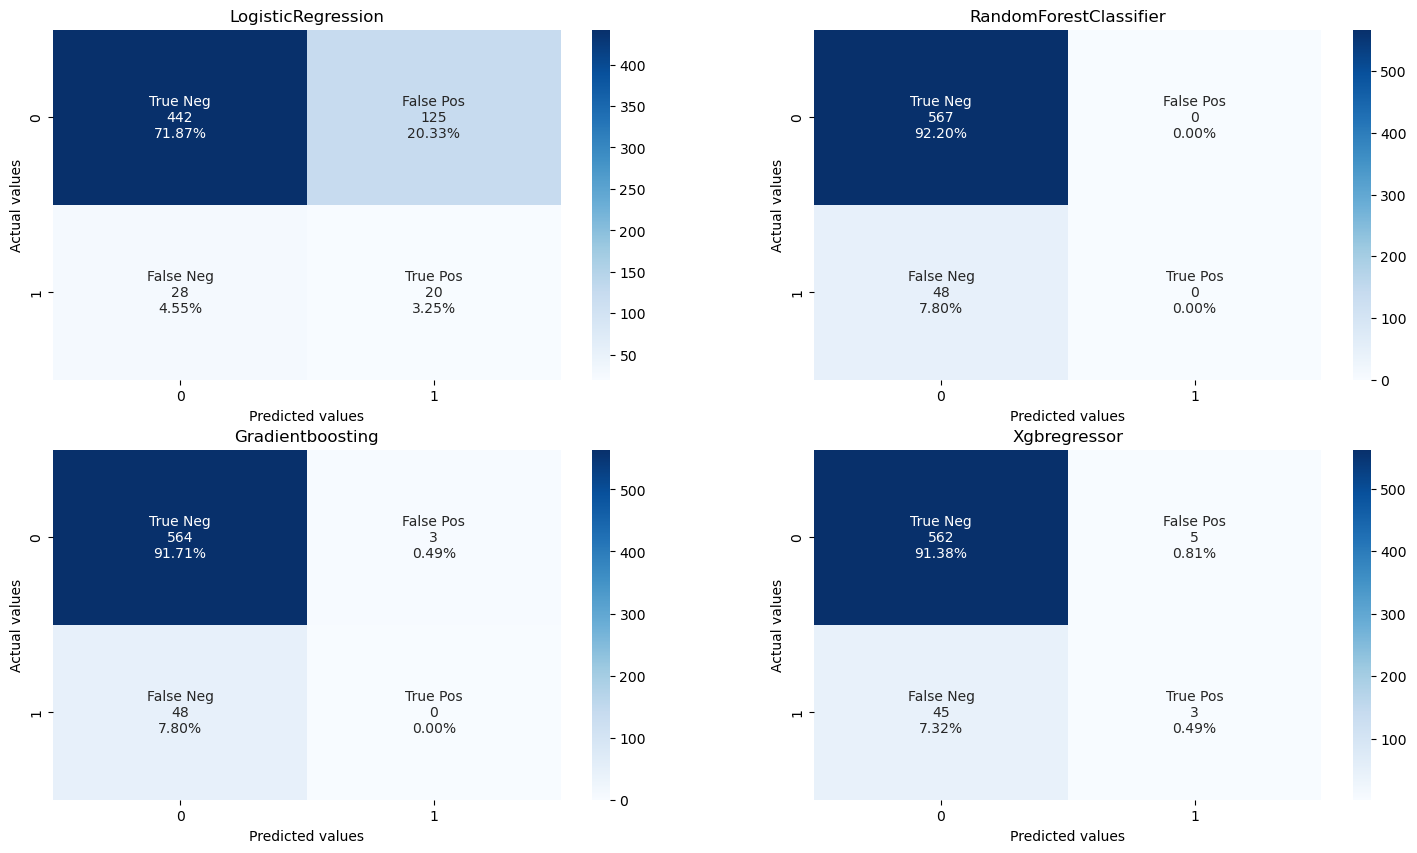

<IPython.core.display.Javascript object>

In [75]:
list_models = [
    "LogisticRegression",
    "RandomForestClassifier",
    "Gradientboosting",
    "Xgbregressor",
]
# Visualisation des matrices de confusion
fig = plt.figure(figsize=(18, 10))

for i in range(len(cm_list)):
    model = list_models[i]
    cm = cm_list[i]
    sub = fig.add_subplot(2, 2, i + 1).set_title(model)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    cm_plot = sns.heatmap(cm, fmt="", annot=labels, cmap="Blues")
    cm_plot.set_xlabel("Predicted values")
    cm_plot.set_ylabel("Actual values")